In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib_venn import venn3
from multiprocessing import Pool
from upsetplot import from_memberships, plot

def get_ko_sensitivity(df, sensitivity_threshold=0.05, ko_col=None):
    return round((df[ko_col] < sensitivity_threshold).sum() / len(df), 2)

def generate_venn(df, col, threshold, axes, sensitivity=0.05, ko_col=None):    
    mask1 = (df["probability_modified_{}".format(col)] >= threshold).values
    mask2 = (df["miCLIP"] == 1).values
    mask3 = (df["m6ACE"] == 1).values
    
    all_intersections = mask1 & mask2 & mask3
    
    m6anet_miclip = (mask1 & mask2) & ~all_intersections
    m6ace_m6anet = (mask1 & mask3) & ~all_intersections
    m6ace_miclip = (mask2 & mask3) & ~all_intersections
    
    m6anet_only = mask1 & ~((mask1 & mask2) | (mask1 & mask3))
    miclip_only = mask2 & ~((mask2 & mask1) | (mask2 & mask3))
    m6ace_only = mask3 & ~((mask3 & mask1) | (mask3 & mask2))

    out1 = venn3(subsets=(m6ace_only.sum(),
                          miclip_only.sum(),
                          m6ace_miclip.sum(),
                          m6anet_only.sum(),
                          m6ace_m6anet.sum(), m6anet_miclip.sum(), all_intersections.sum()),
                 set_labels = ('m6ACE', 'miCLIP', 'm6ANet'), alpha = 0.5, ax=axes[0])

    out2 = venn3(subsets=(get_ko_sensitivity(df[m6ace_only], sensitivity, ko_col),
                          get_ko_sensitivity(df[miclip_only], sensitivity, ko_col),
                          get_ko_sensitivity(df[m6ace_miclip], sensitivity, ko_col),
                          get_ko_sensitivity(df[m6anet_only], sensitivity, ko_col),
                          get_ko_sensitivity(df[m6ace_m6anet], sensitivity, ko_col),
                          get_ko_sensitivity(df[m6anet_miclip], sensitivity, ko_col),
                          get_ko_sensitivity(df[all_intersections], sensitivity, ko_col)),
                 set_labels = ('m6ACE', 'miCLIP', 'm6ANet'), alpha = 0.5, ax=axes[1])
    
    for out in [out1, out2]:
        for text in out.set_labels:
            text.set_fontsize(25)
        for text in out.subset_labels:
            text.set_fontsize(25)
    axes[0].set_title("Sites captured", fontdict={'fontsize': 25})
    axes[1].set_title("Knockout sensitivity", fontdict={'fontsize': 25})

    
def generate_upset_plot(df, col, threshold, fig, ko=False, sensitivity=0.05, ko_col=None):        
    mask1 = (df["probability_modified_{}".format(col)] >= threshold).values
    mask2 = (df["miCLIP"] == 1).values
    mask3 = (df["m6ACE"] == 1).values
    
    all_intersections = mask1 & mask2 & mask3
    
    m6anet_miclip = (mask1 & mask2) & ~all_intersections
    m6ace_m6anet = (mask1 & mask3) & ~all_intersections
    m6ace_miclip = (mask2 & mask3) & ~all_intersections
    
    m6anet_only = mask1 & ~((mask1 & mask2) | (mask1 & mask3))
    miclip_only = mask2 & ~((mask2 & mask1) | (mask2 & mask3))
    m6ace_only = mask3 & ~((mask3 & mask1) | (mask3 & mask2))
    

    
    if not ko:
        upset_df = from_memberships([["m6ACE"], ["miCLIP"], ["m6ACE", "miCLIP"],
                                     ["m6Anet"], ["m6Anet", "m6ACE"], ["m6Anet", "miCLIP"],
                                     ["m6Anet", "m6ACE", "miCLIP"]], data=[m6ace_only.sum(), miclip_only.sum(),
                                                                           m6ace_miclip.sum(), m6anet_only.sum(),
                                                                           m6ace_m6anet.sum(), m6anet_miclip.sum(),
                                                                           all_intersections.sum()])
        plot(upset_df, fig=fig)
    else:
        data = [get_ko_sensitivity(df[m6ace_only], sensitivity, ko_col),
                get_ko_sensitivity(df[miclip_only], sensitivity, ko_col),
                get_ko_sensitivity(df[m6ace_miclip], sensitivity, ko_col),
                get_ko_sensitivity(df[m6anet_only], sensitivity, ko_col),
                get_ko_sensitivity(df[m6ace_m6anet], sensitivity, ko_col),
                get_ko_sensitivity(df[m6anet_miclip], sensitivity, ko_col),
               get_ko_sensitivity(df[all_intersections], sensitivity, ko_col)]
        
        upset_df_ko = from_memberships([["m6ACE"], ["miCLIP"], ["m6ACE", "miCLIP"],
                                     ["m6Anet"], ["m6Anet", "m6ACE"], ["m6Anet", "miCLIP"],
                                     ["m6Anet", "m6ACE", "miCLIP"]], 
                                      data=data)
        plot(upset_df_ko, fig=fig)
        

In [42]:
from pyensembl import Genome
from tqdm.notebook import tqdm

def get_y(info_df, table, col_name):
    g, chrsm = info_df["genomic_position"].values, info_df["chr"].values
    info_df[col_name] = np.array([1 if (g_pos, chr_id) in table.index else 0
                                               for g_pos, chr_id in tqdm(zip(g, chrsm), total=len(g),
                                               desc="Getting label information")]) 
    return info_df


def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    info_df["gene_id"] = info_df["transcript_id"].apply(lambda x: genome.transcript_by_id(x).gene_id)
    return info_df


def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    try:
        tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    except Exception:
        raise ValueError(tx)
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)


In [25]:
chrsm_annot_dir = "/mnt/dataHDD/chris/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/mnt/dataHDD/chris/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/mnt/dataHDD/chris/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

gt_dir = "/mnt/data/chris/gt_mapping_final/"

In [ ]:
m6ace = pd.read_csv("/mnt/dataHDD/chris/annotations/m6ACE_HEK293T.csv.gz").set_index(["End", "Chr"])
miclip = pd.read_csv("/mnt/dataHDD/chris/annotations/miclip_HEK293T.csv.gz").set_index(["End", "Chr"])


model_dir = "/mnt/data/chris/comparison/prod_pooling"
result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
result = add_chromosome_and_gene_info(result)
result = add_genomic_position(result)
result = result.rename({'probability_modified': "probability_modified_prod_pooling"}, axis=1)

result = result[["gene_id", "genomic_position", "transcript_id", "transcript_position", "chr",
                 "probability_modified_prod_pooling"]]
result = result.groupby(["gene_id", "genomic_position", "chr"]).mean().reset_index()
            
result = get_y(result, m6ace, "m6ACE")
result = get_y(result, miclip, "miCLIP")

In [3]:
from statsmodels.stats.multitest import multipletests


cols = ["id", "position", "kmer", "mod_rate_WT", 
        "mod_rate_KO",
        "pval_KO_vs_WT"]
wt_ko_table = pd.read_csv("/mnt/dataHDD/chris/diffmod.table", usecols=cols)
wt_ko_table["padj_xpore"] = multipletests(wt_ko_table.pval_KO_vs_WT, alpha=0.05, method='fdr_bh')[1]
wt_ko_table = wt_ko_table.rename(columns={'id': 'gene_id', 'position': 'genomic_position'})
result = result.merge(wt_ko_table[["pval_KO_vs_WT", "gene_id", "genomic_position"]], 
                                   on=["gene_id", "genomic_position"],
                                   how='left')
result = result.rename(columns={'pval_KO_vs_WT': 'padj_xpore'})
result = result.fillna(1)


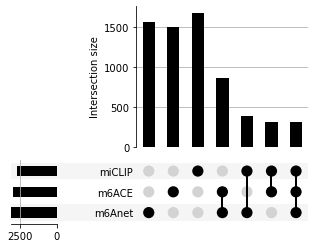

In [4]:
fig = plt.figure(figsize=(20, 30))
generate_upset_plot(result, "prod_pooling", 0.9, fig, ko=False)
# fig.savefig('/home/christopher/protocols_comparison_numbers.svg')

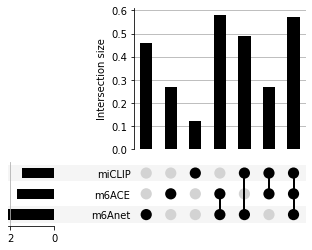

In [5]:
fig = plt.figure(figsize=(20, 30))
generate_upset_plot(result, "prod_pooling", 0.9, fig, ko=True, ko_col="padj_xpore")
# fig.savefig('/home/christopher/protocols_comparison_numbers.svg')

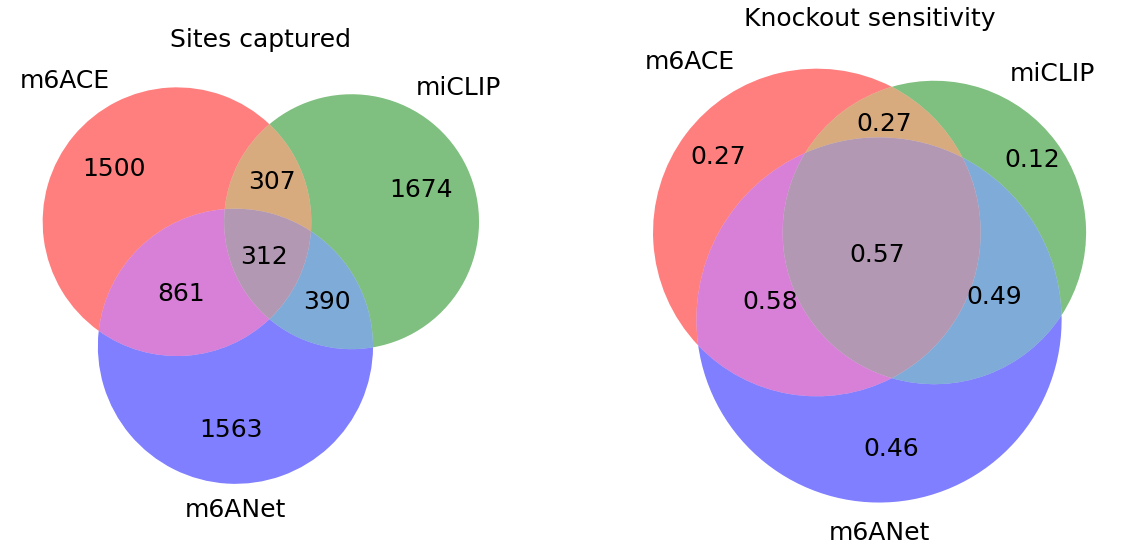

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

generate_venn(result, "prod_pooling", 0.9, axes, ko_col="padj_xpore")
# fig.savefig("/home/christopher/protocols_comparison_venn.svg")

In [10]:
from statsmodels.stats.multitest import multipletests
 
wt_ko_table = pd.read_csv("~/ttest_results.csv.gz")
wt_ko_table["padj_ttest"] = multipletests(wt_ko_table.pvalue, alpha=0.05, method='fdr_bh')[1]

result = result.merge(wt_ko_table[["padj_ttest", "gene_id", "genomic_position"]], 
                                   on=["gene_id", "genomic_position"],
                                   how='left')
result = result.fillna(1)

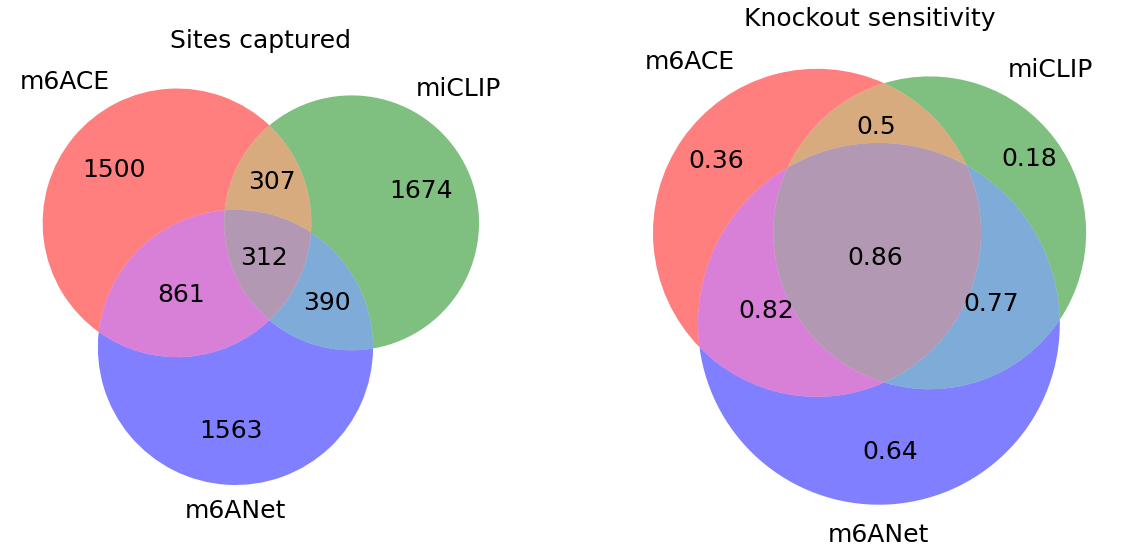

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

generate_venn(result, "prod_pooling", 0.9, axes, ko_col="padj_ttest")
# fig.savefig("/home/christopher/protocols_comparison_venn.svg")

In [15]:
result.to_csv("~/m6anet_miclip_m6ace_hek293t.csv", index=False)

In [14]:
def create_tx_ref(transcript_ids):
    transcript_lengths = []
    for tx_id in tqdm(transcript_ids):
        try:
            tx = genome.transcript_by_id(tx_id)
        except Exception:
            continue
        end_tx = len(tx.sequence)
        if tx.contains_start_codon and tx.contains_stop_codon:
            end_5utr = len(tx.five_prime_utr_sequence)
            end_cds = tx.last_stop_codon_spliced_offset
            if end_tx > end_cds > end_5utr > 0:
                transcript_lengths += [(tx_id,end_5utr,end_cds,end_tx)]
    return pd.DataFrame(transcript_lengths,columns = ['transcript_id','end_5utr','end_cds','end_tx'])

def plot_rel_positions(ax,df,df_transcript_lengths, label):
    df = df.merge(df_transcript_lengths,how='inner',on='transcript_id')
    df['isin_5utr'] = df['transcript_position'] < df['end_5utr']
    df['isin_cds'] = (~df['isin_5utr']) & (df['transcript_position'] < df['end_cds'])
    df['isin_3utr'] = (~df['isin_5utr']) & (~df['isin_cds']) #& (df['tx_pos'] < df['end_tx'])
    len_cds = df['end_cds']-df['end_5utr']
    len_3utr = df['end_tx']-df['end_cds']
    
    assert (len_cds > 0).all()
    assert (len_3utr > 0).all()

    rel_len_5utr = df['isin_5utr']*(df['transcript_position']/df['end_5utr'])
    rel_len_cds = df['isin_cds']*((df['transcript_position']-df['end_5utr'])/len_cds)
    rel_len_3utr = df['isin_3utr']*((df['transcript_position']-df['end_cds'])/len_3utr)
    
    df['rel_5utr'] = rel_len_5utr
    df['rel_cds'] = rel_len_cds
    df['rel_3utr'] = rel_len_3utr
    
    rel_positions = list(rel_len_5utr[rel_len_5utr>0])
    rel_positions += list(rel_len_cds[rel_len_cds>0] + 1)
    rel_positions += list(rel_len_3utr[rel_len_3utr>0] + 2)
    sns.kdeplot(rel_positions, bw='scott', shade=True, cut=True, ax=ax, label=label)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([])
    ######### annotating the x axis   #########
    ax.annotate("", xy=(0, -0.05),xytext=(1,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False)
    ax.annotate("5'UTR",xy=(0.5, -0.2),xytext=(0.5,-0.2),             
                annotation_clip=False)
    ax.annotate("", xy=(1, -0.05),xytext=(2,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False) 
    ax.annotate("CDS",xy=(1.5, -0.2),xytext=(1.5,-0.2),             
                annotation_clip=False)
    ax.annotate("", xy=(2, -0.05),xytext=(3,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False) 
    ax.annotate("3'UTR",xy=(2.5, -0.2),xytext=(2.5,-0.2),             
                annotation_clip=False)
    ax.axvline(1, ymin=0, color='black', linestyle="--")
    ax.axvline(2, ymin=0, color='black', linestyle="--")
    ax.set_xlim([0,3])
    ax.set_ylabel('Density')
#     ax.legend(bbox_to_anchor=(0,1.01,1,0.1),loc='center left',ncol=len(df),mode='expand',frameon=False)
    return ax

def get_modified_positions(inference_df, col, threshold):
    return inference_df[inference_df[col] >= threshold]

In [6]:
sub_df

,transcript_id,transcript_position,n_reads,probability_modified,chr,gene_id,genomic_position,kmer
0,ENST00000641390,879,57,0.344917,chr7,ENSG00000284707,97872366,TGACC
1,ENST00000641784,1411,46,0.200160,chr7,ENSG00000284707,97872366,TGACC


In [70]:
result_tx = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
annot = pd.read_csv(os.path.join(model_dir, '/mnt/data/chris/comparison/data.readcount.labelled'))
result_tx = add_chromosome_and_gene_info(result_tx)
result_tx = add_genomic_position(result_tx)

keys = ["transcript_id", "transcript_position", "gene_id", "genomic_position"]
result_tx = result_tx.merge(annot[keys + ["m6ACE", "miCLIP"]], on=keys)

max_df = []
for _, sub_df in tqdm(result_tx.groupby(["gene_id", "genomic_position"])):
    sub_df = sub_df.reset_index(drop=True)
    max_row = sub_df["n_reads"].argmax()
    max_df.append(sub_df.iloc[max_row].values.reshape(1, -1))
max_df = pd.DataFrame(np.concatenate(max_df), columns=sub_df.columns)


  0%|          | 0/4662 [00:00<?, ?it/s]

  0%|          | 0/75369 [00:00<?, ?it/s]

In [50]:
tx_ref = create_tx_ref(max_df["transcript_id"].unique())


  0%|          | 0/3586 [00:00<?, ?it/s]

/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/softw

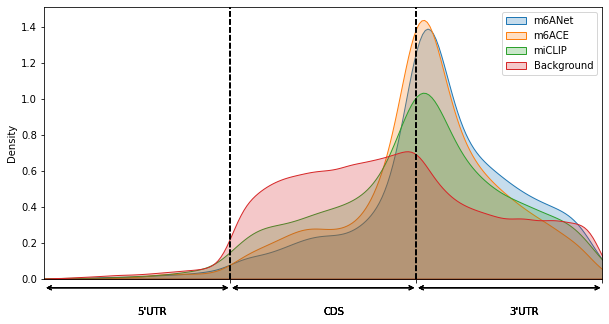

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_rel_positions(ax, get_modified_positions(max_df, "probability_modified", 0.9), tx_ref, label="m6ANet")
plot_rel_positions(ax, get_modified_positions(max_df, "m6ACE", 1), tx_ref, label="m6ACE")
plot_rel_positions(ax, get_modified_positions(max_df, "miCLIP", 1), tx_ref, label="miCLIP")
plot_rel_positions(ax, max_df, tx_ref, label="Background")
plt.legend()
fig.savefig("/home/christopherhendra/m6Anet_metageneplot.svg")

/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/softw

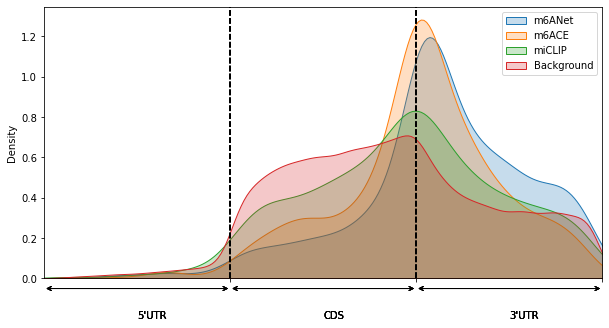

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

max_df_m6ace = max_df[(max_df["miCLIP"] == 0).values & (max_df["probability_modified"] < 0.9).values]
max_df_miclip = max_df[(max_df["m6ACE"] == 0).values & (max_df["probability_modified"] < 0.9).values]
max_df_m6anet = max_df[(max_df["m6ACE"] == 0).values & (max_df["miCLIP"] == 0).values]

plot_rel_positions(ax, get_modified_positions(max_df_m6anet, "probability_modified", 0.9), tx_ref, label="m6ANet")
plot_rel_positions(ax, get_modified_positions(max_df_m6ace, "m6ACE", 1), tx_ref, label="m6ACE")
plot_rel_positions(ax, get_modified_positions(max_df_miclip, "miCLIP", 1), tx_ref, label="miCLIP")
plot_rel_positions(ax, get_modified_positions(result_tx, "probability_modified", 0), tx_ref, label="Background")
plt.legend()
fig.savefig("/home/christopherhendra/m6Anet_metageneplot_individual.svg")

In [54]:
dat = pd.read_csv("/home/christopherhendra/m6anet_outputs_nreads50.tar.gz")
dat = dat.rename(columns={'m6anet_outputs_nreads50/': 'transcript_id'})
all_transcripts = set(os.listdir(gt_dir))
dat = dat[dat["transcript_id"].isin(all_transcripts)].reset_index(drop=True)
dat["transcript_position"] = dat["transcript_position"].astype('int')
dat["probability_modified"] = dat["probability_modified"].astype('float')
dat = add_chromosome_and_gene_info(dat)
dat = add_genomic_position(dat)
dat["n_reads"] = dat["n_reads"].astype('int')

max_df = []
for _, sub_df in tqdm(dat.groupby(["gene_id", "genomic_position"])):
    sub_df = sub_df.reset_index(drop=True)
    max_row = sub_df["n_reads"].argmax()
    max_df.append(sub_df.iloc[max_row].values.reshape(1, -1))

max_df = pd.DataFrame(np.concatenate(max_df), columns=sub_df.columns)


  0%|          | 0/7415 [00:00<?, ?it/s]

  0%|          | 0/147596 [00:00<?, ?it/s]

In [58]:
tx_ref = create_tx_ref(max_df["transcript_id"].unique())


  0%|          | 0/5645 [00:00<?, ?it/s]

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /mnt/dataHDD/chris/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa.pickle


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


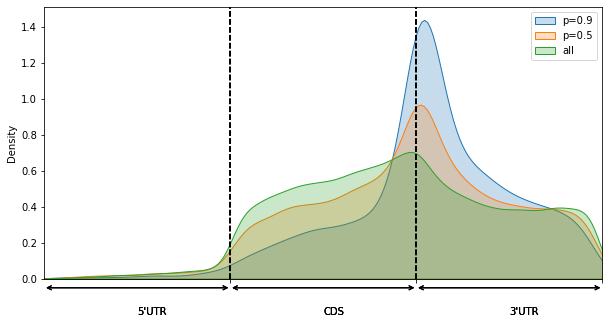

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_rel_positions(ax, get_modified_positions(max_df, "probability_modified", 0.9), tx_ref, label="p=0.9")
plot_rel_positions(ax, get_modified_positions(max_df, "probability_modified", 0.5), tx_ref, label="p=0.5")
plot_rel_positions(ax, get_modified_positions(max_df, "probability_modified", 0), tx_ref, label="all")
plt.legend()
fig.savefig("/home/christopherhendra/m6Anet_metageneplot_yk.svg")